In [1]:
import tensorflow as tf
import numpy as np
from util import ImShow as I
import matplotlib.pyplot as plt

In [6]:
def batches(l, n):
    """Yield successive n-sized batches from l, the last batch is the left indexes.
        and n-sized batch index from l with replacement
    """
    for i in xrange(0, l, n):
        yield range(i,min(l,i+n)), np.random.choice(l, size= min(n,l-i))

class Fluent_Autoencoder(object):
    def __init__(self, sess, input_dim_list=[784,400]):
        """input_dim_list must include the original data dimension"""
        assert len(input_dim_list) >= 2
        self.W_list = []
        self.encoding_b_list = []
        self.decoding_b_list = []
        self.dim_list = input_dim_list
        ## Encoders parameters
        for i in range(len(input_dim_list)-1):
            init_max_value = np.sqrt(6. / (self.dim_list[i] + self.dim_list[i+1]))
            self.W_list.append(tf.Variable(tf.random_uniform([self.dim_list[i],self.dim_list[i+1]],
                                                             np.negative(init_max_value),init_max_value)))
            self.encoding_b_list.append(tf.Variable(tf.random_uniform([self.dim_list[i+1]],-0.1,0.1)))
        ## Decoders parameters
        for i in range(len(input_dim_list)-2,-1,-1):
            self.decoding_b_list.append(tf.Variable(tf.random_uniform([self.dim_list[i]],-0.1,0.1)))
        ## Placeholder for input
        self.input_x = tf.placeholder(tf.float32,[None,self.dim_list[0]])
        self.input_y = tf.placeholder(tf.float32,[None,self.dim_list[0]])
        ## coding graph :
        last_layer = self.input_x
        for weight,bias in zip(self.W_list,self.encoding_b_list):
            hidden = tf.sigmoid(tf.matmul(last_layer,weight) + bias)
            last_layer = hidden
        self.hidden = hidden 
        ## decode graph:
        for weight,bias in zip(reversed(self.W_list),self.decoding_b_list):
            hidden = tf.sigmoid(tf.matmul(last_layer,tf.transpose(weight)) + bias)
            last_layer = hidden
        self.recon = last_layer
        self.cost = tf.reduce_mean(tf.square(self.recon - self.input_y))
        #self.cost = tf.losses.log_loss(self.recon, self.input_x)
        self.train_step = tf.train.AdamOptimizer().minimize(self.cost)
        sess.run(tf.global_variables_initializer())

    def fit(self, X, sess, learning_rate=0.15,
            iteration=200, batch_size=50, init=False,verbose=False):
        assert X.shape[1] == self.dim_list[0]
        if init:
            sess.run(tf.global_variables_initializer())
        
        sample_size = X.shape[0]
        for i in xrange(iteration):
            for one_batch,random_batch in batches(sample_size, batch_size):
                sess.run(self.train_step,feed_dict = {self.input_x:X[one_batch],self.input_y:X[random_batch]})
            if verbose and i%20==0:
                e = self.cost.eval(session = sess,feed_dict = {self.input_x: X[one_batch],self.input_y:X[random_batch]})
                print "    iteration : ", i ,", cost : ", e

    def transform(self, X, sess):
        return self.hidden.eval(session = sess, feed_dict={self.input_x: X})

    def getRecon(self, X, sess):
        return self.recon.eval(session = sess,feed_dict={self.input_x: X})

In [9]:
import time
x = np.load(r"./data/4_other_x.npk")
start_time = time.time()
with tf.Graph().as_default():
    with tf.Session() as sess:
        ae = Fluent_Autoencoder(sess = sess, input_dim_list=[784,400,200])
        error = ae.fit(x ,sess = sess, learning_rate=0.01, batch_size = 50, iteration = 300, verbose=True)
        R = ae.getRecon(x, sess = sess)

        error = ae.fit(x ,sess = sess, learning_rate=0.01, batch_size = 50, iteration = 300, verbose=True)
        R1 = ae.getRecon(x, sess = sess)
        print "Runing time:" + str(time.time() - start_time) + " s"

    iteration :  0 , cost :  0.048444554
    iteration :  20 , cost :  0.053036038
    iteration :  40 , cost :  0.054620903
    iteration :  60 , cost :  0.054529805
    iteration :  80 , cost :  0.05263999
    iteration :  100 , cost :  0.050875902
    iteration :  120 , cost :  0.05365664
    iteration :  140 , cost :  0.05508995
    iteration :  160 , cost :  0.05080965
    iteration :  180 , cost :  0.0561825
    iteration :  200 , cost :  0.057643395
    iteration :  220 , cost :  0.05500994
    iteration :  240 , cost :  0.059190016
    iteration :  260 , cost :  0.05167322
    iteration :  280 , cost :  0.059150938
    iteration :  0 , cost :  1.0065763e-09
    iteration :  20 , cost :  4.6764354e-10
    iteration :  40 , cost :  7.103967e-10
    iteration :  60 , cost :  4.0959092e-10
    iteration :  80 , cost :  6.307432e-10
    iteration :  100 , cost :  2.3766344e-10
    iteration :  120 , cost :  2.580608e-09
    iteration :  140 , cost :  2.114203e-09
    iteration :  16

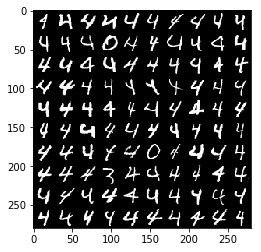

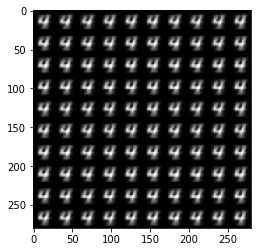

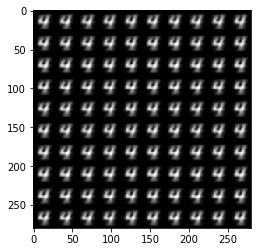

In [10]:
Xpic = I.tile_raster_images(X = x, img_shape=(28,28), tile_shape=(10,10))
plt.imshow(Xpic,cmap='gray')
plt.show()
Rpic = I.tile_raster_images(X = R, img_shape=(28,28), tile_shape=(10,10))
plt.imshow(Rpic,cmap='gray')
plt.show()
R1pic = I.tile_raster_images(X = R1, img_shape=(28,28), tile_shape=(10,10))
plt.imshow(R1pic,cmap='gray')
plt.show()